# *Pós-graduação em Inteligência Artificial par Negócios*
### *Trabalho Final - Machine Learning*

**Disciplina:** Machine Learning

**Professor:** André Juan Costa Vieira

**Turma:** 

**Nomes dos Integrantes:** 

1-

2-

3-

## Qualidade de vinhos. 

Você foi contratado como cientista de dados pela famosa vinícola **"Vini Tradizionali di Manduria"** para analisar todos os aspectos dos vinhos produzidos. Diversas questões foram levantadas, como: Compreender os padrões das características que proporcionam boas safras e a qualidade de novos vinhos produzidos, antes que a comunidade mundial **"Vins Spectaculaires"** os deguste, apontar quais são os novos **"blends"** que podem ter continuidade no desenvolvimento, dentre várias outras atividades que visam as boas tomadas de decisões, sempre com o intuito de servir os melhores rótulos, aumentando os lucros e diminuindo os gastos.        

A equipe de enólogos faz estudos frequentes para verificar as características de cada vinho, colocando-os em planilhas. Para melhor compreensão dos dados, descreveram o que significado de cada propriedade.   


##### Descrição 

**0. Color:** Se o vinho é tinto vermelho ou branco

**1. Fixed Acidity:** Qtd.de Ácido não volátil, aquele que não evapora fácil

**2. Volatile Acidity:** Teor de ácido acético que leva a um sabor desagradável de vinagre

**3. Citric Acid:** Um tipo de ácido que age como conservante para aumentar o nível de acidez em pequena quantidade para adicionar aroma e sabor

**4. Residual Sugar:** Qtd. de açúcar restante depois da fermentação, mais de 45g/litro é doce

**5. Chlorides:** Qtd. de sal

**6. Free Sulfur Dioxide:** Componente que impede crescimento microbiano e a oxidação do vinho

**7. Total Sulfur Dioxide:** Qtd. de SO2 (dióxido de enxofre)

**8. Density:** Densidade do vinho,

**9. pH:** Nível de acidez ou potencial hidrogeniônico

**10. Sulphates:** Um adicional que contribui para níveis de SO2 e é 
antimicróbico e antioxidante 

**11. Alcohol:** Qtd. de álcool

**12. Qualidade:** Notas de 3 a 9

# Questões

### Importe todas as bibliotecas necessárias na célula abaixo
##### Organize-as de forma crescente em relação ao tamanho da frase

In [ ]:
import os
import sys
import warnings
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, auc, mean_absolute_error, mean_squared_error, r2_score
)

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

### Tratamento dos Dados


Sir. Pounce, enólogo de longa data, especializado em vinhos italianos, descobriu que estão faltando alguns valores nas planilhas, e que outros dados foram alterados pelo ex-funcionário Smeagle, dispensado por degustar vinhos 'preciosos'.   

**Utilize o dataset 'wines_preprocessing.csv' para fazer as questões abaixo.**

1- Busque os valores faltantes no dataset e trate-os.

2- Busque valores incongruentes no dataset, imprima e os trate. 

3- Valide seus tratamentos com o dataset **'wines.csv'**, demonstrando se foi possível manter as distribuições de forma adequada.

In [ ]:
df_pre = pd.read_csv("wines_pre_processing.csv")
df_val  = pd.read_csv("wines.csv")

df_pre.columns = [c.strip().lower().replace(" ", "_") for c in df_pre.columns]
df_val.columns = [c.strip().lower().replace(" ", "_") for c in df_val.columns]

print("Pré-processamento:", df_pre.shape)
print("Validação:", df_val.shape)
df_pre.head()


In [ ]:
print("Valores faltantes antes do tratamento:\n", df_pre.isna().sum())

num_cols = df_pre.select_dtypes(include=[np.number]).columns
cat_cols = df_pre.select_dtypes(exclude=[np.number]).columns

imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

df_pre[num_cols] = imputer_num.fit_transform(df_pre[num_cols])
df_pre[cat_cols] = imputer_cat.fit_transform(df_pre[cat_cols])

print("Valores faltantes depois do tratamento:\n", df_pre.isna().sum())


In [ ]:
df_pre.columns = df_pre.columns.str.strip().str.lower()

for col in df_pre.columns:
    if col not in ['color']:
        df_pre[col] = pd.to_numeric(df_pre[col], errors='coerce')

print(df_pre.isna().sum())

for col in df_pre.select_dtypes(include=['float64']).columns:
    df_pre[col].fillna(df_pre[col].median(), inplace=True)

df_pre.info()

In [ ]:
mask_incongruente = (
    (df_pre["ph"] <= 0) | (df_pre["ph"] > 14) |
    (df_pre["alcohol"] < 0) | (df_pre["alcohol"] > 20) |
    (df_pre["quality"] < 0) | (df_pre["quality"] > 10)
)

print("Qtd valores incongruentes:", mask_incongruente.sum())
display(df_pre[mask_incongruente].head())

df_pre = df_pre[~mask_incongruente].reset_index(drop=True)
print("Shape após tratamento:", df_pre.shape)


In [ ]:
for col in ["alcohol", "residual_sugar", "ph", "quality"]:
    stat, p = ks_2samp(df_pre[col], df_val[col])
    print(f"Coluna {col}: KS={stat:.3f}, p={p:.3f}")


O dono da vinícola, Sir. Donald Shelby, tem um filho cursando especialização em ciência de dados, que, ao deparar-se com o dataset, pediu a você que, ao invés de ficar tratando dados com 'essas' técnicas triviais, fizesse um algoritmo de regressão logística para encontrar os valores faltantes na coluna 'Alcohol'. O Sr. Shelby é um homem conhecido como mafioso e considera seu filho um gênio, por isso, você, com fortes receios de sofrer consequências inusitadas por ordem do Don Corleone da atualidade, acatou o "pedido".


4- Desenvolver um algoritmo de regressão logística visando preencher os dados faltantes da coluna "Alcohol". Em seguida, valide os resultados com o dataset **"wines.csv"**, apresentando todas as métricas de classificação estudadas. 

5- Você, ao ver os resultados encontrados, se adiantou e fez um modelo de regressão polinomial para dirimir a questão. Em seguida, validou os resultados com o dataset **"wines.csv"**, utilizando todas as métricas de regressão estudadas. Por fim, escreverá um e-mail explicando o motivo <u>técnico</u> que o levou a não utilizar a regressão logística neste problema, bem como qual a melhor técnica que encontrou para tratar os valores faltantes.

In [ ]:
df_lr = df_pre.copy()

mask_nan = df_lr["alcohol"].sample(frac=0.2, random_state=42).index
df_lr.loc[mask_nan, "alcohol"] = np.nan

X = df_lr.drop(columns=["alcohol"])
y = (df_lr["alcohol"].dropna() > df_lr["alcohol"].median()).astype(int)  # binário

X_train, X_test, y_train, y_test = train_test_split(
    X.loc[y.index], y, test_size=0.2, random_state=42
)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train.select_dtypes(include=np.number), y_train)

y_pred = log_reg.predict(X_test.select_dtypes(include=np.number))

print("Métricas Regressão Logística:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


In [ ]:
df_poly = df_pre.copy()

X = df_poly.drop(columns=["alcohol"])
y = df_poly["alcohol"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train.select_dtypes(include=np.number))
X_test_poly  = poly.transform(X_test.select_dtypes(include=np.number))

lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)
y_pred = lin_reg.predict(X_test_poly)

print("Métricas Regressão Polinomial:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)
print("R²:", r2_score(y_test, y_pred))

### Análise Exploratória
**Utilize o dataset 'wines.csv'**

A enóloga Marilyn Monroe, direta do Sir. Pounce, tomou conhecimento de suas habilidades exploratórias e requereu gráficos "chiques, reuscados, enfeitados e nada triviais" que mostrassem, de forma interativa todos os dados e seus respectivos insights. A principal exigência é de que as paletas de cores sejam harmônicas, de modo que possam ser utilizadas em apresentações. Para isso, sugeriu a documentação a seguir:
[Colors Palettes](https://plotly.com/python/builtin-colorscales/)

1- Utilize um countplot para averiguar a quantidade de vinhos por cada avaliação de qualidade. 
Separare entre vinhos tintos e brancos, fazendo um gráfico para cada tipo.

2- Utilize um jointplot para descrever a relação entre álcool e açucar. Utilizar o tipo 'KDE'.

3- Utilize um boxplot para verificar se existe algum vinho que seja considerado um outlier. Utilize **x = 'quality'** e **y='residual sugar'**. Identificando os outliers, crie um novo dataframe, utilize um barplot para contabilizar a quantidade de vinhos tintos
e brancos por qualidade de modo que as barras estejam sobrepostas em relação ao tipo de vinho.   

4- Faça um gráfico de correlação e encontre quais são as 'features' que contém correlações
positivas e negativas fortes  entre si. Em seguida, utilize o scatterplot, colocando no eixo "x" e "y"
cada variável correlata e descreva por escrito o motivo da distribuição e o sentido vetorial estarem apresentados
das respectivas formas.

**ps**: Para este problema, entenda como correlações fortes valores menores que -0.4 e maiores que 0.4.

In [ ]:
sns.countplot(data=df_val, x="quality", hue="color")
plt.title("Distribuição de qualidade por tipo de vinho")
plt.show()

In [ ]:
sns.jointplot(data=df_val, x="alcohol", y="residual_sugar", kind="kde", hue="color")
plt.show()

In [ ]:
sns.boxplot(data=df_val, x="quality", y="residual_sugar")
plt.title("Boxplot açúcar residual por qualidade")
plt.show()

In [ ]:
q3 = df_val["residual_sugar"].quantile(0.75)
iqr = q3 - df_val["residual_sugar"].quantile(0.25)
limite = q3 + 1.5 * iqr
df_sem_outlier = df_val[df_val["residual_sugar"] <= limite]

sns.countplot(data=df_sem_outlier, x="quality", hue="color", dodge=False)
plt.title("Vinhos sem outliers - distribuição de qualidade por cor")
plt.show()

In [ ]:
corr = df_val.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="RdBu", center=0)
plt.title("Matriz de correlação")
plt.show()

# Modelos Supervisionados 

### Classificação
**Utilize o dataset 'wine_classification.csv'.**

Após alguns meses, o filho do Sir. Donald Shelby, Chuck Norris Shelby, mais conhecido como "El Chavo del Ocho", em decorrência de seu "notório" saber e comportamento extrovertido, ~para ser eufemista~, foi promovido a "*head*" de Machine Learning, vulgo seu chefe. 

Com suas inusitadas e inovadoras ideias, pediu que você criasse três modelos de árvores, um do tipo "random" e dois do tipo "boost", pois havia descoberto que a otimização pelo gradiente descendente era considerada como "*The American Dream*". Não obstante, gostaria de analisar o gráfico de importância das features.

Ademais, requereu que utilizasse o algoritmo SVM, pelo fato do "kernel trick" performar bem em problemas de altas dimensionalidades. Um KNN "cairia bem também, vamos utilizar por mero desencargo de consciência", disse.  

Em seu discurso inflamado, se pronunciava: "Precisamos realizar tais façanhas nunca vistas na história da Inteligência Artificial, desde que as redes neurais foram introduzidas por Walter Pitts e Warren McCulloch em 1943. Vamos predizer tudo que quisermos, independentemente da uva utilizada na produção. Eu transformarei nossa vinícola na melhor do mundo, pois sou detentor do saber". Tudo dito numa reunião contendo 12 pessoas, trabalhadores braçais inclusos. Tal discurso invejou os oráculos delfos e os lembraram de Sócrates em seu julgamento, antes de morrer. 

Após tamanhas proclamações, apontou em sua direção e disse: **"VOCÊ, É..., VOCÊ MESMO**, irás fazer todo o processo por conta própria, e eu direi se o que fazes está correto! Não utilizarás Auto-ML, pois eu, ~professor~, quero ter certeza de que entende seu labor e suas nuâncias". 

Você, cansado e entediado de tantas lorotas, se retirou da reunião com "dores" na região abdominal, porém ainda recebeu um e-mail lhe instruindo a comparar os resultados de todas as implementações, escolher o melhor modelo e utilizar métodos de otimização de hiperparâmetro.  

Em suma?

1- Crie um pipeline que contenha ao menos 05 tipos diferentes de algoritmos de classificação. 

2- Crie um DataFrame que contenha todos os resultados de todos os algoritmos utilizados, inclusive a métrica ROC AUC.

3- Comparar os resultados, escolher o melhor modelo e otimizar os parâmetros. Ao fim, faça um gráfico da ROC AUC.


In [ ]:
df_class = pd.read_csv("wine_classification.csv")
df_class.columns = [c.strip().lower().replace(" ", "_") for c in df_class.columns]

X = df_class.drop(columns=["quality"])
y = df_class["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelos = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

resultados = []
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test) if hasattr(modelo, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    auc_ = roc_auc_score(y_test, y_proba, multi_class="ovr") if y_proba is not None else None
    
    resultados.append([nome, acc, f1, auc_])

df_resultados = pd.DataFrame(resultados, columns=["Modelo", "Acurácia", "F1", "ROC AUC"])
df_resultados

Após todos seus esforços, o amado chefe lhe pediu para utilizar um algoritmo de classificação que ele ouviu falar, criado pelo matemático inglês Thomas Bayes. Cabe a você, mais uma vez aplicar o algoritmo e apresentar os resultado. Em seguida, faça uma breve explicação do principal problema desse método para solucionar problemas complexos.  

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print("Resultados Naive Bayes:")
print(classification_report(y_test, y_pred))

Dr. Anton Ego marcou uma data para comparecer na vinícula e degustar seus melhores rótulos. Nascido na França e o enólogo mais famoso do mundo, Anton era temido pelas suas análises minuciosas e certeiras. As críticas eram tão serveras que tão severas que 80% das vinículas eram fechadas pela falta de aceitação do mercado. Apenas =~ 19.99% sobreviviam sem danos consideráveis e somente $0.1x10^{-15}$% se tornavam uma lenda.

Chuck tomava leite da papoula para suportar tamanha disruptura emocional. Sir.Donald, tomado pela a ansiedade, estava com seus pruridos mentais em Nárnia até que sua esposa, Srta.Audrey Hepburn assumiu a liderança do projeto com a serenidade de um bebê.

Primeiramente ordenou que todos os vinhos que já vinham há algum tempo em processo de envelhecimento em barricas de carvalho fossem engarrafados e que amostras de todos fossem coletadas para análise. 

Sua maior preocupação é que somente sejam servidos os vinhos de nota oito ou nove, pois ambos são de mesmíssima qualidade, ficando a avaliação a critério da subjetividade palatal do degustador. Em **<u>hipótese nenhuma</u>** um vinho que não tenha tais notas pode ser servido.

De todas as novas garrafas, serão servidas somente três que você autorizar. O Dr. Ego só toma vinho tinto!


Sabendo que você já tinha um modelo validado para solucionar este tipo de problema, pediu que o usasse com a base **'desafio.csv''**. Ao fim, crie uma célula e copie os 3 vinhos que escolheu para registrar sua resposta. 


In [ ]:
df_desafio = pd.read_csv("desafio.csv")
df_desafio.columns = [c.strip().lower().replace(" ", "_") for c in df_desafio.columns]

df_selecao = df_desafio[df_desafio["quality"].isin([8,9])]

df_resposta = df_selecao.sample(3, random_state=42)
df_resposta

# Por falta da tabela "color", filtrei apenas pela qualidade (8 ou 9)

In [ ]:
# --- CÉLULA: desafio final ---
df_desafio = pd.read_csv("desafio.csv")
df_desafio.info()


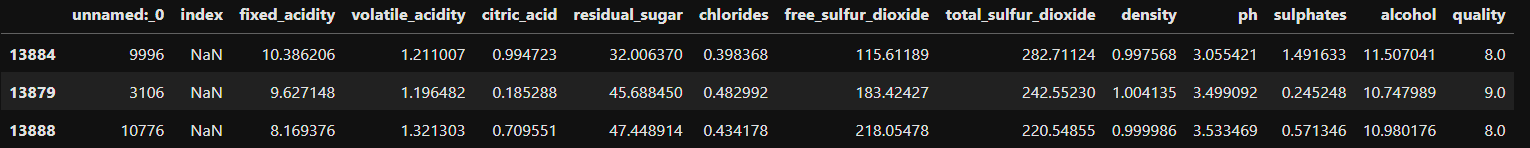